# Brainster TwinCar Project

## Dataset Setup

This section mounts Google Drive, extracts the Stanford Cars dataset ZIP file, and ensures the workspace contains all necessary image files for training and testing. This guarantees reproducibility and centralized data management across environments.


In [1]:
# Mount Google Drive and extract Stanford Cars dataset zip file.
# This block sets up your workspace and unzips the dataset if it doesn't exist.
from google.colab import drive
import zipfile, os

drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/stanford_cars.zip'
extract_dir = '/content/stanford_cars'
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
print("✅ Dataset extracted")

Mounted at /content/drive
✅ Dataset extracted


## Data Preprocessing

Here, we parse the MATLAB annotation files to create CSVs containing filenames and labels for training and testing. The code removes missing or corrupted files, ensuring only valid images are included, which prevents errors during model training and evaluation.


In [2]:
# Parse the MATLAB .mat annotations and build train/test label CSVs.
# Remove missing images to avoid training/test errors.
import scipy.io
import pandas as pd

train_annos = scipy.io.loadmat(f"{extract_dir}/car_devkit/devkit/cars_train_annos.mat")['annotations'][0]
train_rows = [[x[5][0], int(x[4][0]) - 1] for x in train_annos]
df_train = pd.DataFrame(train_rows, columns=["filename", "label"])
df_train.to_csv('/content/train_labels.csv', index=False)

test_annos = scipy.io.loadmat(f"{extract_dir}/car_devkit/devkit/cars_test_annos.mat")['annotations'][0]
test_rows = [[x[4][0]] for x in test_annos]
df_test = pd.DataFrame(test_rows, columns=["filename"])
df_test.to_csv('/content/test_labels.csv', index=False)
print("✅ Saved train/test labels CSV")

train_root = f"{extract_dir}/cars_train/cars_train"
test_root = f"{extract_dir}/cars_test/cars_test"

# Drop image files that don't exist
# This ensures your DataLoader won't break due to missing files.
df_train = pd.read_csv('/content/train_labels.csv')
df_train = df_train[df_train['filename'].apply(lambda f: os.path.exists(os.path.join(train_root, f)))]
df_train.to_csv('/content/train_labels.csv', index=False)
df_test = pd.read_csv('/content/test_labels.csv')
df_test = df_test[df_test['filename'].apply(lambda f: os.path.exists(os.path.join(test_root, f)))]
df_test.to_csv('/content/test_labels.csv', index=False)
print("✅ Cleaned dataset")

/tmp/ipython-input-2-3017994914.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_rows = [[x[5][0], int(x[4][0]) - 1] for x in train_annos]


✅ Saved train/test labels CSV
✅ Cleaned dataset


## Datasets & DataLoaders

We define a custom PyTorch Dataset class to read images and labels from CSVs, applying data augmentations (random crop, flip, rotation) for robust training and normalization for both train and test splits. The DataLoader objects efficiently batch and serve data during model training and evaluation.


In [3]:
# PyTorch Dataset for images/labels from CSV.
# Applies image augmentations for train, normalization for train/test/val.
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

class StanfordCarsFromCSV(Dataset):
    def __init__(self, root_dir, csv_file, transform=None, has_labels=True):
        self.root_dir = root_dir
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.has_labels = has_labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.root_dir, row['filename'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        if self.has_labels:
            return image, int(row['label'])
        return image, row['filename']

# Standard normalization/augmentation for robust transfer learning.
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# Split for cross-validation (10% validation)
df_all = pd.read_csv('/content/train_labels.csv')
df_train, df_val = train_test_split(df_all, test_size=0.1, stratify=df_all['label'], random_state=42)
df_train.to_csv('/content/train_split.csv', index=False)
df_val.to_csv('/content/val_split.csv', index=False)

train_dataset = StanfordCarsFromCSV(train_root, '/content/train_split.csv', train_transform)
val_dataset = StanfordCarsFromCSV(train_root, '/content/val_split.csv', test_transform)
test_dataset = StanfordCarsFromCSV(test_root, '/content/test_labels.csv', test_transform, has_labels=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=2)

## Model Setup

We load a pretrained ResNet50, freeze all convolutional layers for transfer learning efficiency, and replace the final classification layer to output predictions for 196 vehicle classes. The model is then moved to the appropriate device (GPU or CPU).


In [4]:
# Load pretrained ResNet50, freeze all layers, replace classifier for 196-class output.
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 196)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 120MB/s]


## Training & Validation with Metrics

This section trains the model for a set number of epochs, optimizing only the classifier head. It tracks and logs training/validation loss, accuracy, F1-score, precision, and recall at each epoch. Macro-averaged metrics provide a fair assessment across all classes.


In [5]:
from sklearn.metrics import f1_score, precision_score, recall_score

train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []
val_f1_list, val_precision_list, val_recall_list = [], [], []

num_epochs = 15
print("🚗 Training ResNet50...")

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_loss = total_loss / total
    train_acc = correct / total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # ---- Validation ----
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    val_preds, val_targets = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            v_loss = criterion(outputs, labels)
            val_loss += v_loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    # ---- Compute macro metrics ----
    val_f1 = f1_score(val_targets, val_preds, average='macro', zero_division=0)
    val_precision = precision_score(val_targets, val_preds, average='macro', zero_division=0)
    val_recall = recall_score(val_targets, val_preds, average='macro', zero_division=0)
    val_f1_list.append(val_f1)
    val_precision_list.append(val_precision)
    val_recall_list.append(val_recall)

    scheduler.step()
    print(
        f"Epoch {epoch+1} | "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
        f"Val F1: {val_f1:.4f} | Val Prec: {val_precision:.4f} | Val Rec: {val_recall:.4f}"
    )


🚗 Training ResNet50...
Epoch 1 | Train Loss: 4.7388 | Train Acc: 0.0827 | Val Loss: 4.2039 | Val Acc: 0.1583 | Val F1: 0.1285 | Val Prec: 0.1633 | Val Rec: 0.1534
Epoch 2 | Train Loss: 3.6045 | Train Acc: 0.3191 | Val Loss: 3.7858 | Val Acc: 0.2564 | Val F1: 0.2190 | Val Prec: 0.2602 | Val Rec: 0.2579
Epoch 3 | Train Loss: 2.9970 | Train Acc: 0.4451 | Val Loss: 3.4528 | Val Acc: 0.2748 | Val F1: 0.2429 | Val Prec: 0.2846 | Val Rec: 0.2723
Epoch 4 | Train Loss: 2.5755 | Train Acc: 0.5662 | Val Loss: 3.4052 | Val Acc: 0.3239 | Val F1: 0.2962 | Val Prec: 0.3439 | Val Rec: 0.3251
Epoch 5 | Train Loss: 2.3917 | Train Acc: 0.5965 | Val Loss: 3.1931 | Val Acc: 0.3411 | Val F1: 0.3127 | Val Prec: 0.3535 | Val Rec: 0.3421
Epoch 6 | Train Loss: 2.2203 | Train Acc: 0.6291 | Val Loss: 3.1810 | Val Acc: 0.3436 | Val F1: 0.3213 | Val Prec: 0.3626 | Val Rec: 0.3458
Epoch 7 | Train Loss: 2.0778 | Train Acc: 0.6769 | Val Loss: 3.0809 | Val Acc: 0.3607 | Val F1: 0.3360 | Val Prec: 0.3759 | Val Rec: 0.35

In [6]:
print(val_f1_list)
print(val_precision_list)
print(val_recall_list)


[0.12849050255420444, 0.21897403293758516, 0.24288412284193817, 0.2962135523105563, 0.3127328154038838, 0.32126700019074356, 0.33599666629654934, 0.33092760352631695, 0.34755134920164177, 0.36408952275548906, 0.35299804649412914, 0.3782580976727056, 0.37173993872114114, 0.37122812744811545, 0.3839796008313415]
[0.16329441308849452, 0.26016557713808103, 0.2846076410072279, 0.3438884062213998, 0.3534614407701142, 0.36255481754806484, 0.3759049340681993, 0.3730501109078856, 0.39741548134405275, 0.41034382201098885, 0.3978843491363631, 0.43513469240510055, 0.42989074417645845, 0.42351395769763117, 0.43579706708734633]
[0.15343780369290572, 0.2579446064139942, 0.27227891156462586, 0.32510932944606413, 0.3420796890184645, 0.3458090379008745, 0.35935374149659866, 0.35586734693877553, 0.3711734693877551, 0.3900024295432459, 0.37461127308066083, 0.39352526724975706, 0.38894557823129244, 0.38940719144800773, 0.408114674441205]


## Loss & Accuracy Curves

Plots show the model's training and validation loss and accuracy over epochs, helping visualize model convergence, potential overfitting, and the effectiveness of the chosen hyperparameters.


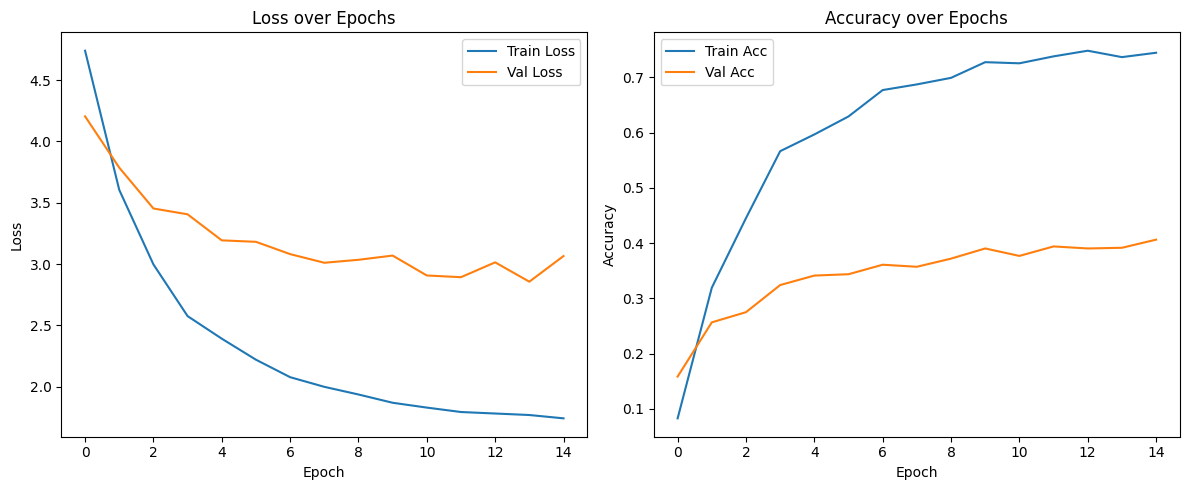

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig("train_val_curves.png", bbox_inches='tight')
plt.show()


## F1, Precision, and Recall

Validation F1-score, precision, and recall are plotted over epochs, offering insight into the model's performance across all classes—especially important for imbalanced class distributions.


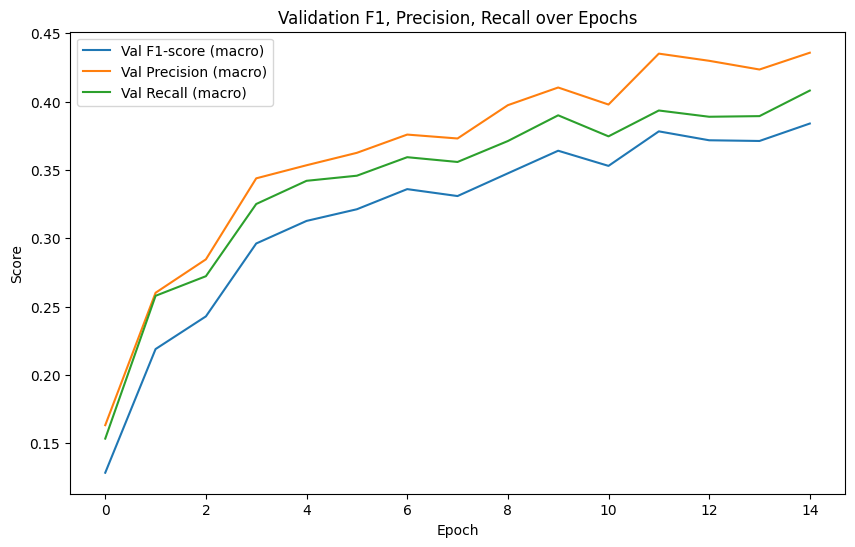

In [8]:
plt.figure(figsize=(10,6))
plt.plot(val_f1_list, label='Val F1-score (macro)')
plt.plot(val_precision_list, label='Val Precision (macro)')
plt.plot(val_recall_list, label='Val Recall (macro)')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation F1, Precision, Recall over Epochs')
plt.legend()
plt.savefig("val_f1_prec_recall_curves.png", bbox_inches='tight')
plt.show()


## Save Model

After training, the model's weights are saved locally and backed up to Google Drive, ensuring results are reproducible and deployable for inference or sharing.


In [9]:
# Save model checkpoint to disk and backup to Drive for submission or future inference.
torch.save(model.state_dict(), 'resnet50_finetuned.pth')
import shutil
shutil.copy('resnet50_finetuned.pth', '/content/drive/MyDrive/resnet50_finetuned.pth')
print("✅ Model saved to Drive")

✅ Model saved to Drive


## Test Set Predictions & CSV

The trained model predicts class labels for each image in the unlabeled test set. The predictions are saved as a CSV file, mapping filenames to predicted class names—ready for submission or external evaluation.


In [10]:
# Predict classes for test set images (no labels), save predictions as CSV for evaluation or Kaggle submission.
preds, filenames = [], []
with torch.no_grad():
    for images, names in test_loader:
        images = images.to(device)
        outputs = model(images)
        pred = outputs.argmax(dim=1).cpu().numpy()
        preds.extend(pred)
        filenames.extend(names)
print("✅ Test predictions complete")
import scipy.io
meta = scipy.io.loadmat(f"{extract_dir}/car_devkit/devkit/cars_meta.mat")
class_names = [x[0] for x in meta['class_names'][0]]
predicted_names = [class_names[i] for i in preds]
results_df = pd.DataFrame({'filename': filenames,'class_name': predicted_names})
results_df.to_csv('/content/test_predictions_named.csv', index=False)
print("✅ test_predictions_named.csv saved")

✅ Test predictions complete
✅ test_predictions_named.csv saved


## Classification Report & Confusion Matrix

On the validation set, a full classification report (precision, recall, F1 per class) and a confusion matrix are generated and saved. Additional plots show the most accurate and most confused classes, providing actionable insights for future improvements.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Saved: /content/classification_report.csv


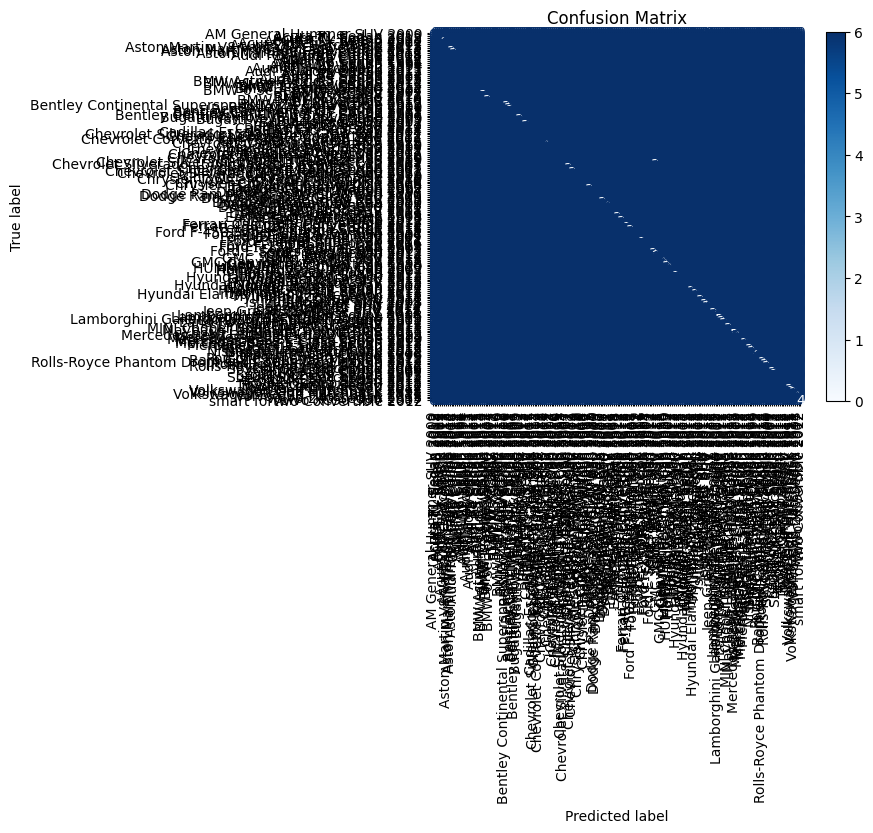

In [11]:
# Evaluate on the validation set, saving full classification report (precision/recall/F1 for all classes) and confusion matrix plot.
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
pd.DataFrame(report).transpose().to_csv('/content/classification_report.csv')
print('✅ Saved: /content/classification_report.csv')
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation='vertical', cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.savefig('/content/classification_matrix.png')
plt.show()


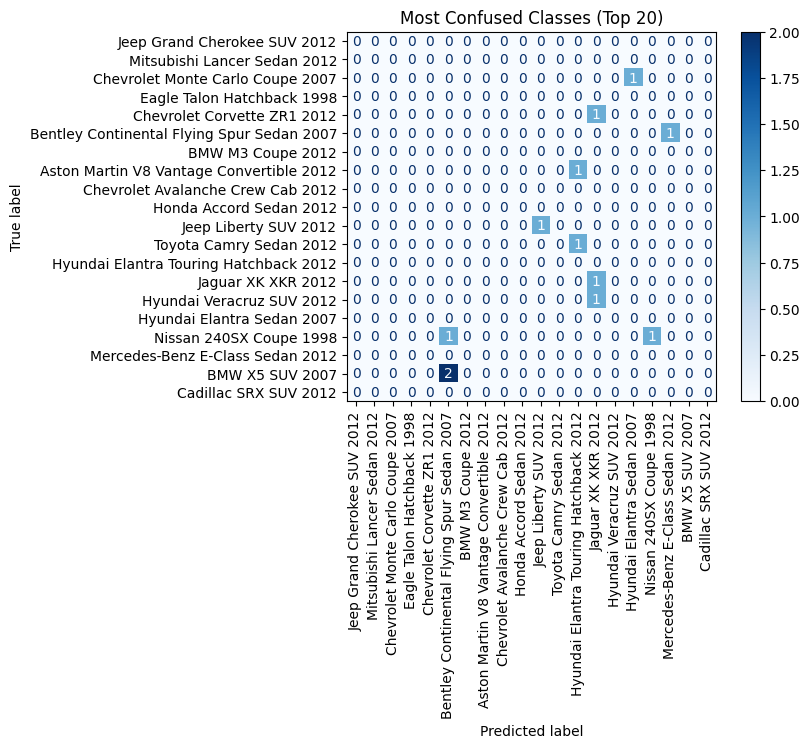

In [12]:
import numpy as np

# Find classes with most off-diagonal confusion (excluding diagonal)
off_diagonal = cm.copy()
np.fill_diagonal(off_diagonal, 0)
most_confused = np.argsort(off_diagonal.sum(axis=1))[::-1][:20]  # Top 20

cm_top = cm[np.ix_(most_confused, most_confused)]
labels_top = [class_names[i] for i in most_confused]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_top, display_labels=labels_top)
disp.plot(xticks_rotation=90, cmap='Blues', values_format='d')
plt.title('Most Confused Classes (Top 20)')
plt.savefig("top20_confused.png", bbox_inches='tight')
plt.show()


/tmp/ipython-input-13-1404852108.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_acc, x='accuracy', y='class', palette='Blues_d')


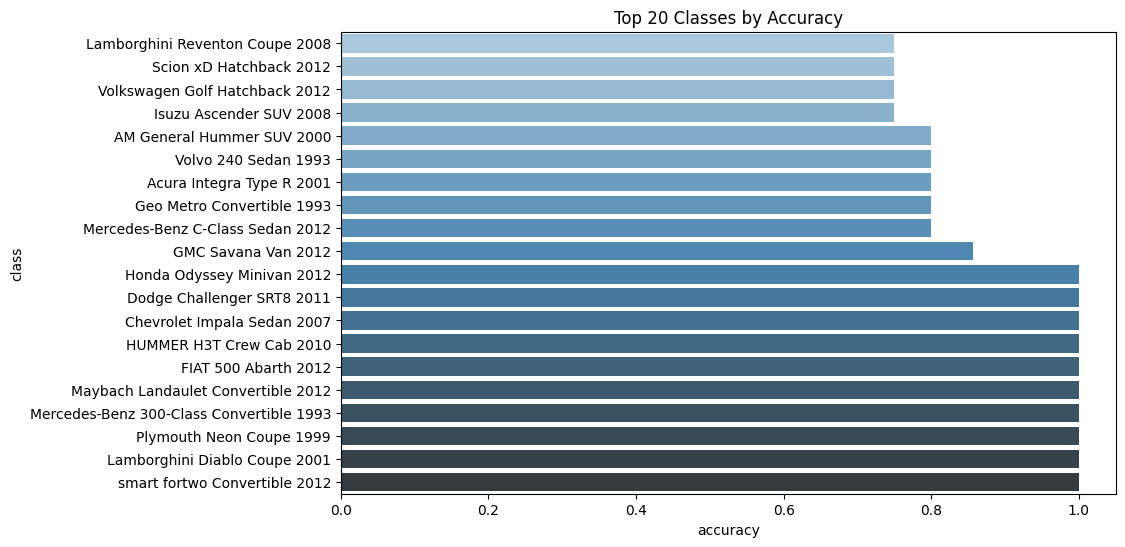

In [13]:
import seaborn as sns
import pandas as pd

acc_per_class = cm.diagonal() / cm.sum(axis=1)
df_acc = pd.DataFrame({'class': class_names, 'accuracy': acc_per_class})
top_acc = df_acc.sort_values('accuracy').tail(20)  # 20 best
plt.figure(figsize=(10,6))
sns.barplot(data=top_acc, x='accuracy', y='class', palette='Blues_d')
plt.title('Top 20 Classes by Accuracy')
plt.savefig("top20_accuracy.png", bbox_inches='tight')
plt.show()


## Grad-CAM++ Visualization

We generate Grad-CAM++ heatmaps for several test images, visualizing which regions of the image the model focuses on for its predictions. This helps interpret and validate the model's behavior.


In [14]:
!pip install -U grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.3 MB/s 

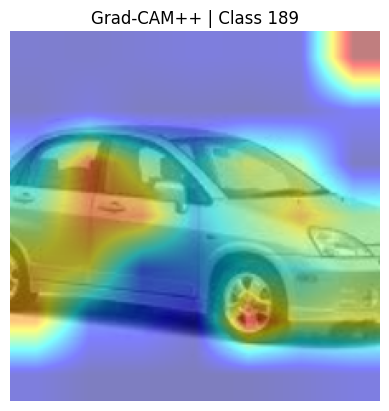

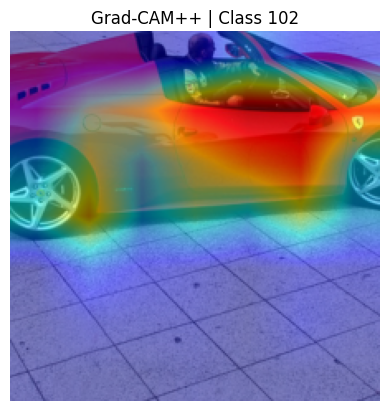

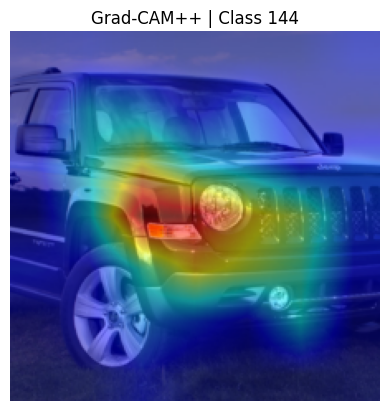

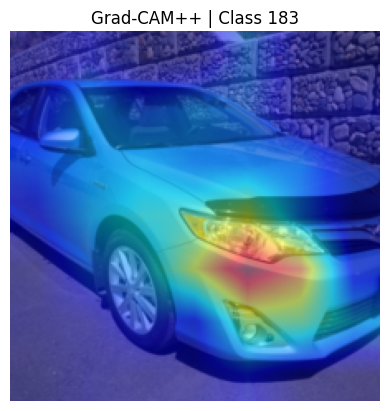

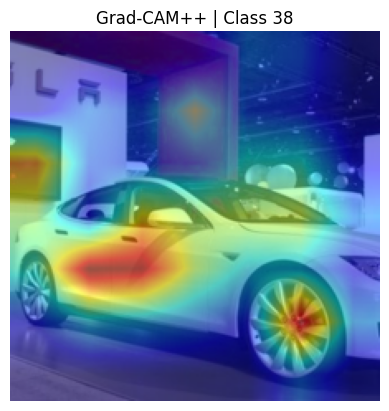

In [15]:
# Visualize model attention with Grad-CAM++ for 5 test images.
# Helps explain which parts of the image drive each prediction, for presentation or debugging.
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
os.makedirs('/content/gradcam_outputs', exist_ok=True)
model.eval().to(device)
target_layer = model.layer4[-1]
cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])
for i in range(5):
    try:
        image_tensor = test_dataset[i][0]
        input_tensor = image_tensor.unsqueeze(0).to(device)
        outputs = model(input_tensor)
        pred_idx = outputs.argmax().item()
        targets = [ClassifierOutputTarget(pred_idx)]
        cam_input = input_tensor.requires_grad_()
        grayscale_cam = cam(input_tensor=cam_input, targets=targets)
        if grayscale_cam is None or grayscale_cam[0] is None:
            continue
        grayscale_cam = grayscale_cam[0]
        image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
        image_np = (image_np * np.array(imagenet_std)) + np.array(imagenet_mean)
        image_np = np.clip(image_np, 0, 1)
        vis = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)
        filename = f"/content/gradcam_outputs/campp_{i:02d}_class_{pred_idx}.png"
        plt.imsave(filename, vis)
        plt.imshow(vis)
        plt.title(f"Grad-CAM++ | Class {pred_idx}")
        plt.axis("off")
        plt.show()
    except Exception as e:
        print(f"❌ Failed on image {i}: {e}")

## Gradio App (Optional)

A Gradio demo app allows interactive predictions and Grad-CAM++ explanations for uploaded car images, making the model accessible for testing and demonstration purposes.


In [17]:
import gradio as gr
import torch
from torchvision import models, transforms
from PIL import Image as PILImage
import numpy as np
import scipy.io
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Paths
extract_dir = "./stanford_cars"  # Update if needed
model_path = "./resnet50_finetuned.pth"  # Update if needed

# Load class names dynamically
meta = scipy.io.loadmat(f"{extract_dir}/car_devkit/devkit/cars_meta.mat")
class_names = [x[0] for x in meta['class_names'][0]]

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False
model.fc = torch.nn.Linear(model.fc.in_features, 196)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Setup transforms
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# Setup GradCAM++
target_layer = model.layer4[-1]
cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])

def predict_and_explain(img: PILImage.Image):
    image_resized = img.resize((224, 224))
    input_tensor = test_transform(image_resized).unsqueeze(0).to(device).requires_grad_()
    with torch.no_grad():
        outputs = model(input_tensor)
        pred_idx = outputs.argmax().item()
    targets = [ClassifierOutputTarget(pred_idx)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    image_np = np.array(image_resized).astype(np.float32) / 255.0
    cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)
    car_name = class_names[pred_idx]
    return PILImage.fromarray(cam_image), f"Prediction: {car_name} (Class ID: {pred_idx})"

demo = gr.Interface(
    fn=predict_and_explain,
    inputs=gr.Image(type="pil", label="Upload Car Image"),
    outputs=[gr.Image(label="Grad-CAM++ Output"), gr.Text(label="Prediction")],
    title="🚗 TwinCar: Vehicle Classifier Explainability Demo",
    description="Upload an image of a car. The model will classify it and visualize where it looked (Grad-CAM++)."
)

if __name__ == "__main__":
    demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ad67779fb10bbd27ce.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
